In [322]:
import numpy as np
from itertools import product
from typing import Tuple, Union
import matplotlib.pyplot as plt
import commpy as cp
from scipy import signal

np.random.seed(0)

In [323]:
# Generating bits to be transmitted
number_bits = 100
Fs = 50000
M = 4
U = 20 # Upsampling factor
modulation = "pam" # pam or qam
data = np.random.randint(0,2, number_bits)
print(data[0:50])

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1]


In [324]:
def mod_demod(data: Union[np.ndarray, list],M: int, delta:int=2, mod_name:str="pam", type:str="mod") -> Tuple[np.ndarray, np.ndarray, np.ndarray, dict]:
	if np.log2(M) % 2 != 0:
		raise Exception("Only acept log2(M) multiple of 2")
	number_bits_per_symbol = int(np.log2(M))
	binary_combinations = list(product([0,1], repeat=number_bits_per_symbol))
	canonical_constellation = np.arange(-(M-1), M-1+delta, delta)
	normalized_constellation = canonical_constellation/np.sqrt(np.mean(np.power(canonical_constellation, 2)))
	if type=="mod":
		data_reshaped = np.reshape(data, (int(len(data)//number_bits_per_symbol), number_bits_per_symbol))
		dict_result = {str(binary_combination): symbol for binary_combination, symbol in zip(binary_combinations, canonical_constellation)}
		result = np.array([dict_result[str(tuple(bits_symbol))] for bits_symbol in data_reshaped])
	elif type=="demod":
		dict_result = {str(symbol): binary_combination for binary_combination, symbol in zip(binary_combinations, canonical_constellation)}
		result = np.array([dict_result[str(symbol)] for symbol in data]).flatten()
	else:
		raise Exception("Function only accept 'mod' or 'demod' value for parameter type")

	return (result, canonical_constellation, normalized_constellation, dict_result)

symbols, canonical_constellation, normalized_constellation, dict_symbols = mod_demod(data, M)

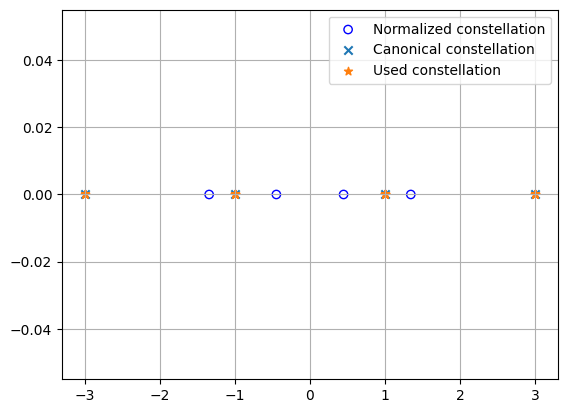

{'(0, 0)': -3, '(0, 1)': -1, '(1, 0)': 1, '(1, 1)': 3}


In [325]:
plt.figure()
plt.scatter(normalized_constellation, np.zeros(len(normalized_constellation)), marker='o', label="Normalized constellation", facecolors='none', edgecolors="b")
plt.scatter(canonical_constellation, np.zeros(len(canonical_constellation)), marker='x', label="Canonical constellation")
plt.scatter(symbols, np.zeros(len(symbols)), marker='*', label="Used constellation")
plt.legend()
plt.grid()
plt.show()
print(dict_symbols)

In [326]:
bits, canonical_constellation, normalized_constellation, dict_symbols = mod_demod(symbols, M, type="demod")

def ber_calculation(input: np.ndarray, output: np.ndarray):
	return np.sum(np.logical_not(np.equal(input,output)).astype(int))/len(input)

print(ber_calculation(data, bits))

0.0


In [327]:
# Upsampling the signal
def upsample(vector, U):
	new_vector = np.zeros(len(vector)*U)
	new_vector[::U] = vector

	return new_vector
	
upsampled_tx = upsample(symbols, U)

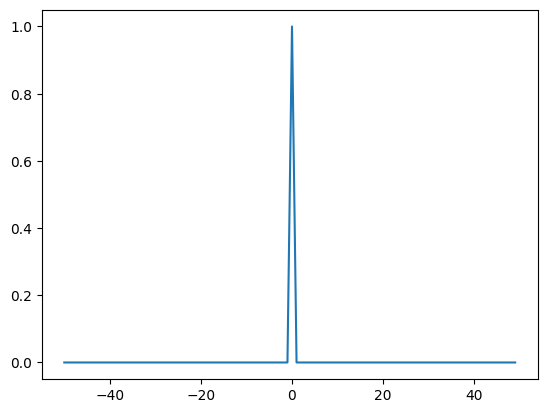

100
[-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.]
0.05
0


In [328]:
# Root raised cosine
x_rrc, y_rrc = cp.rrcosfilter(100, 0, 1/U, 1)
plt.figure()
plt.plot(x_rrc, y_rrc)
plt.show()
print(len(y_rrc))
print(x_rrc)
print(1/20)
print(np.sum(y_rrc==0))

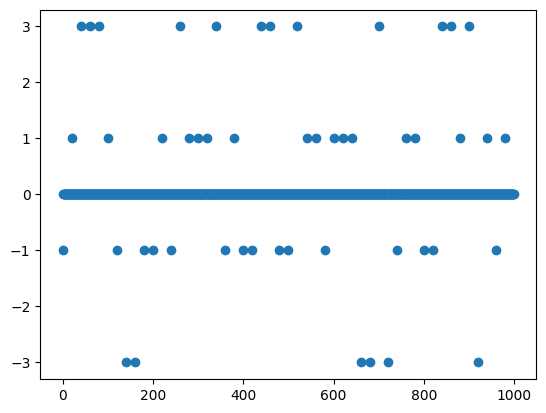

In [329]:
# Convolving symbols with shaping pulse (using Filtfilt to avoid filter delay)
tx_signal_shaping_pulse = signal.filtfilt(y_rrc, 1, upsampled_tx)
plt.figure()
plt.scatter(np.arange(len(tx_signal_shaping_pulse)), tx_signal_shaping_pulse)
plt.show()

In [330]:
# Creating a noise in according to SNR value and inserting into signal tx
SNR_db = 5
power_x = np.mean(np.power(tx_signal_shaping_pulse,2))
noise = np.sqrt(power_x/(np.power(10,SNR_db/10)))*np.random.randn(len(tx_signal_shaping_pulse))
noise_power = np.mean(np.power(noise,2))
rx = tx_signal_shaping_pulse+noise
print(10*np.log10(power_x/noise_power))

5.175334474798525


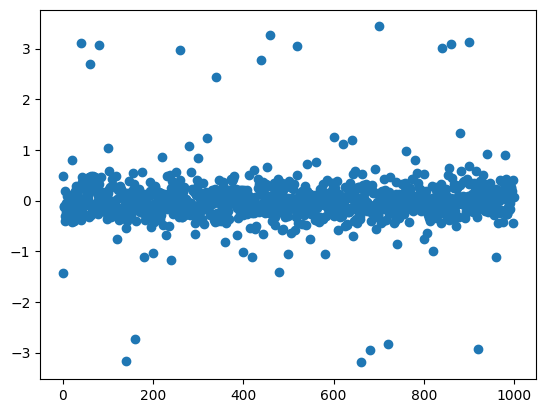

In [331]:
# Matched filter in reception
h_rx = np.conj(np.flip(y_rrc))
rx_signal_shaping_pulse = signal.filtfilt(h_rx, 1, rx)
# rx_signal_shaping_pulse = np.convolve(h_rx, tx_signal_shaping_pulse)
plt.figure()
plt.scatter(np.arange(len(rx_signal_shaping_pulse)), rx_signal_shaping_pulse)
plt.show()

In [332]:
def downsample(vector, factor):
	new_vector = vector[::factor]

	return new_vector

downsampled_symbols = downsample(rx_signal_shaping_pulse, U)
recovered_symbols = np.around(downsampled_symbols)

def ser_calculation(input: np.ndarray, output: np.ndarray):
	return np.sum(np.logical_not(np.isclose(input.astype(np.float64),output.astype(np.float64))).astype(int))/len(input)
print(ser_calculation(symbols, recovered_symbols))

0.04
